<a href="https://colab.research.google.com/github/AliEbadi110/Natural-Language-Processing-Text-Classification-Sample-Projects/blob/main/03_NLP_PyTorch_Text_Classification_Spam_Detection_LSTM_SMS_Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP - PyTorch - Text Classification - Spam Detection - LSTM - SMS Spam**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 1. Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Datasets/smsspamcollection.tsv', sep='\t')
df.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [ ]:
df = df.drop(columns=['length', 'punct'])

In [ ]:
df.columns = ['labels', 'data']

## 2. Data Overview

In [ ]:
df.shape

(5572, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  5572 non-null   object
 1   data    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.describe()

,labels,data
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## 3. Target Variable Preprocessing

In [ ]:
df['labels'].describe()

count     5572
unique       2
top        ham
freq      4825
Name: labels, dtype: object

In [ ]:
df['labels'].value_counts()

ham     4825
spam     747
Name: labels, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

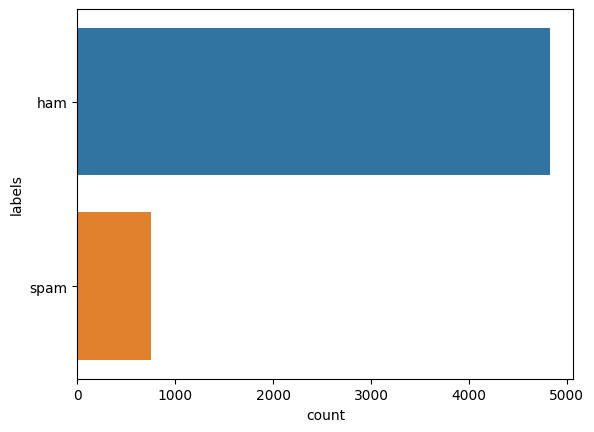

In [ ]:
sns.countplot(data=df, y='labels')

In [ ]:
df['labels'].isnull().sum()

0

In [ ]:
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})

## 4. Handling Missing Values

In [ ]:
df.isnull().sum()

labels    0
data      0
dtype: int64

<Axes: >

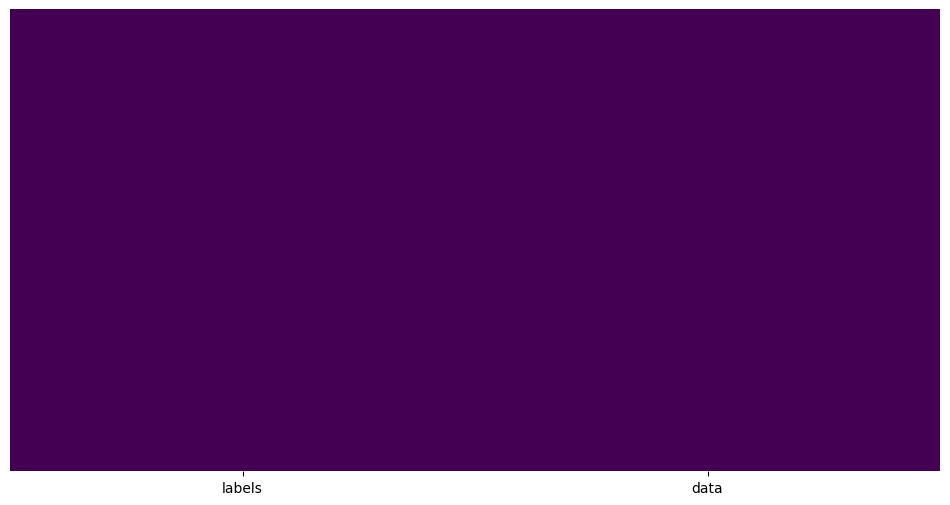

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## 5. Train_Test_Split

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.33)

In [ ]:
df_train.shape

(3733, 2)

## 6. Preprocessing

In [ ]:
word2idx = {'<PAD>': 0}
idx = 1
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx +=1

In [ ]:
len(word2idx)

10655

In [ ]:
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentence_as_int)

In [ ]:
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentence_as_int)

## 7. Generating Training Batches

In [ ]:
def data_generator(X, y, batch_size=32):
  X, y = shuffle(X, y)
  n_batches = int(np.ceil(len(y))/batch_size)
  for i in range(n_batches):
    end_idx = min ((i+1) * batch_size, len(y))
    X_batch = X[i*batch_size:end_idx]
    y_batch = y[i*batch_size:end_idx]

    # pading
    max_len = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len - len(x))
      X_batch[j] = pad + x

    X_batch = torch.from_numpy(np.array(X_batch)).long()
    y_batch = torch.from_numpy(np.array(y_batch)).long()

    yield X_batch, y_batch

In [ ]:
for inputs, targets in data_generator(train_sentences_as_int, df_train.labels):
  print('inputs', inputs, 'shape:', inputs.shape)
  print('targets', targets, 'shape:', targets.shape)
  break

inputs tensor([[   0,    0,    0,  ...,   35,  155,  584],
        [   0,    0,    0,  ...,   70,  417,  115],
        [   0,    0,    0,  ...,  283, 8303, 2144],
        ...,
        [   0,    0,    0,  ..., 2312, 1357, 3108],
        [   0,    0,    0,  ..., 5920, 5921, 9012],
        [   0,    0,    0,  ...,   13, 7067,  318]]) shape: torch.Size([32, 37])
targets tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 1, 1]) shape: torch.Size([32])


In [ ]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.labels)

## 8. Build Model

In [ ]:
class Model(nn.Module):

  def __init__(self, n_vocab, embed_dim, n_hidden, n_layers, n_outputs):
    super().__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.L = n_layers
    self.K = n_outputs
    self.embed = nn.Embedding(self.V, self.D)
    self.lstm = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
    self.sig = nn.Sigmoid()

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    out = self.embed(X)
    out, _ = self.lstm(out, (h0, c0))
    out, _ = torch.max(out, 1)
    out = self.fc(out)
    out = self.sig(out)
    return out

In [ ]:
model = Model(len(word2idx), 20, 15, 1, 1)
model.to(device)

Model(
  (embed): Embedding(10655, 20)
  (lstm): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

## 9. Train Model

In [ ]:
def batch_gd(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    train_loss = []
    for inputs, targets in train_gen():
      targets = targets.view(-1, 1).float()
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_gen():
      targets = targets.view(-1, 1).float()
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    print(f'Epoch{it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test_Loss{test_loss:.4f}')

  return train_losses, test_losses


In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, 15)

Epoch1/15, Train Loss: 0.5060, Test_Loss0.3824
Epoch2/15, Train Loss: 0.3471, Test_Loss0.3223
Epoch3/15, Train Loss: 0.2785, Test_Loss0.2547
Epoch4/15, Train Loss: 0.2089, Test_Loss0.2125
Epoch5/15, Train Loss: 0.1598, Test_Loss0.1694
Epoch6/15, Train Loss: 0.1236, Test_Loss0.1464
Epoch7/15, Train Loss: 0.0999, Test_Loss0.1523
Epoch8/15, Train Loss: 0.0816, Test_Loss0.1275
Epoch9/15, Train Loss: 0.0686, Test_Loss0.1223
Epoch10/15, Train Loss: 0.0566, Test_Loss0.1095
Epoch11/15, Train Loss: 0.0494, Test_Loss0.1064
Epoch12/15, Train Loss: 0.0426, Test_Loss0.1034
Epoch13/15, Train Loss: 0.0378, Test_Loss0.0990
Epoch14/15, Train Loss: 0.0320, Test_Loss0.0929
Epoch15/15, Train Loss: 0.0275, Test_Loss0.0904


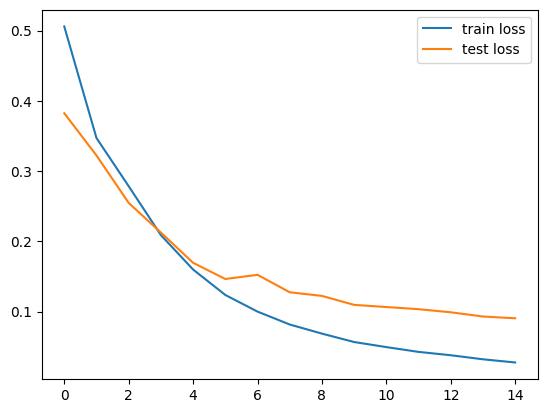

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

## 10. Evaluate

In [ ]:
all_outputs = np.array([])
all_targets = np.array([])
with torch.no_grad():
  for inputs, targets in test_gen():
    targets = targets.view(-1, 1).float()
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    y_val = np.round(outputs.numpy()).flatten()
    all_outputs = np.append(all_outputs, y_val)
    all_targets = np.append(all_targets, targets)

In [ ]:
print(classification_report(all_outputs, all_targets))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1597
         1.0       0.86      0.92      0.89       227

    accuracy                           0.97      1824
   macro avg       0.93      0.95      0.94      1824
weighted avg       0.97      0.97      0.97      1824



In [ ]:
print(confusion_matrix(all_outputs, all_targets))

[[1564   33]
 [  19  208]]


## 11. Predict a sample

In [ ]:
text = 'hi. i will call you later. i am busy now'
text

'hi. i will call you later. i am busy now'

In [ ]:
tokens = text.lower().split()
text_int = [word2idx[token] for token in tokens if token in word2idx]

In [ ]:
text_tensor = torch.from_numpy(np.array([text_int]))

In [ ]:
with torch.no_grad():
  out = model(text_tensor.to(device))
out

tensor([[0.4353]])